In [1]:
####### os, pickle
import os
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from funciones import* 
from imblearn.over_sampling import SMOTE 
from collections import Counter

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
from main import *

X_cat: (5111, 6383) y_cat: (5111,)
X: (51646, 10055) y: (51646,)
X_redux: (51646, 65) y_redux: (51646,)


## Entrenamiento con variable descripción transformada en array de palabras mediante nltk, bag of wors y TF-IDF

In [3]:
os.getcwd()

'c:\\Users\\metal\\Trabajos Bootcamp\\Proyecto Final\\juanito_v2.0\\Datos'

In [4]:
os.chdir(r'C:\Users\metal\Trabajos Bootcamp\Proyecto Final\juanito_v2.0\Modelos')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

oversampling = SMOTE(sampling_strategy=0.30) # usamos oversampling sintético podemos elegir el nivel de oversampling con  sampling_strategy=0.80
X_train_smote, y_train_smote = oversampling.fit_resample(X_train, y_train) #Se obtienen nuevos X e y

In [6]:
Counter(y_train_smote)

Counter({0: 31010, 1: 9303})

In [7]:
xgbmodel = XGBClassifier()
xgbmodel.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [13]:
# version simple que corre con CV = 2
params={ 'base_score': [0.5], # prediccion inicial
         #'booster': ['gbtree'],# (gbtree, gblinear, dart)
     'colsample_bylevel': [1],
     'colsample_bytree': [0.8], #aletoreidad en selección de columnas de cada arbol
     'learning_rate': [0.05], # 
     'max_depth': [3], # default=6
     #'max_leaves': [5,10], #default=0
     'min_child_weight': [1], # minimo numero samples por hoja
     #'missing': [np.nan], # si queremos reemplazar los missings por un numero
     #'n_estimators': [100,200], # default=100 numero de arboles [100,150,200,250,300,350,400]
     'n_jobs': [-1], # trabajos en paralelo
     #'predictor': None, #default=auto
     'random_state': [0], # seed para generar los folds
     'reg_alpha': [0.01], # L1 regularitacion
     'reg_lambda': [0.01], # L2 regularitacion
     'scale_pos_weight': [1], #default=1
     #'tree_method': None, #default=auto
     'subsample': [0.9]} # ratio de muestras por cada arbol default=1

In [24]:
params={ 'base_score': [0.5], # prediccion inicial
         #'booster': ['gbtree'],# (gbtree, gblinear, dart) default=gbtree
     'colsample_bylevel': [1],
     'colsample_bytree': [0.8], #aletoreidad en selección de columnas de cada arbol
     'learning_rate': [0.05], # [0.05,0.1]
     'max_depth': [4], #[2,3,4] 
     #'max_leaves': [5,10], #[5,10]
     'min_child_weight': [1], # minimo numero samples por hoja
     #'missing': [np.nan], # si queremos reemplazar los missings por un numero
     #'n_estimators': [100,200], # 100 es valor default de numero de arboles [100,150,200,250,300,350,400]
     'n_jobs': [-1], # trabajos en paralelo
     #'predictor': ['gpu_predictor'], #default=auto --- Prediction using GPU. Used when tree_method is gpu_hist. only recommended for performing prediction tasks.
     'random_state': [0], # seed para generar los folds
     'reg_alpha': [0.01], # L1 regularitacion
     'reg_lambda': [0.01], # L2 regularitacion
     'scale_pos_weight': [1],
     #'tree_method': ['gpu_hist'],
     'subsample': [0.9]} # ratio de muestras por cada arbol 

In [25]:
scoring = ['roc_auc']
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                   param_grid = params,
                   scoring = scoring,
                   cv = 2,  # 3 soporta máx 1 iteracion de parametros , es decir 6 fits como mucho
                   n_jobs=-1,
                   refit = 'roc_auc',
                   verbose = 2)

In [26]:
model_result_xgboost = grid_solver.fit(X_train_smote, y_train_smote)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [27]:
model_result_xgboost.best_params_

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_jobs': -1,
 'random_state': 0,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'scale_pos_weight': 1,
 'subsample': 0.9}

In [28]:
model_result_xgboost.cv_results_

{'mean_fit_time': array([2600.61831212, 3223.84113348, 3448.41549671]),
 'std_fit_time': array([328.87866902,  59.42346442,  62.57965052]),
 'mean_score_time': array([101.2131778 ,  38.88206875,  34.0226016 ]),
 'std_score_time': array([29.12381828, 11.23477924,  1.1862638 ]),
 'param_base_score': masked_array(data=[0.5, 0.5, 0.5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_colsample_bylevel': masked_array(data=[1, 1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0.8, 0.8, 0.8],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 3, 4],
              mask=[False, False, False],
        fill_value

In [29]:
os.getcwd()

'C:\\Users\\metal\\Trabajos Bootcamp\\Proyecto Final\\juanito_v2.0\\Modelos'

In [30]:
fh = open('m_XGBoost_PCA_v2','wb')
#fh = open('df_smote30_train_test(redux).pkl','wb')
pickle.dump(model_result_xgboost,fh)
fh.close()

In [31]:
results_cv=model_result_xgboost.cv_results_
results=pd.DataFrame(results_cv)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_score,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,...,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample,params,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,2600.618312,328.878669,101.213178,29.123818,0.5,1,0.8,0.05,2,1,...,0.01,0.01,1,0.9,"{'base_score': 0.5, 'colsample_bylevel': 1, 'c...",0.937400,0.951163,0.944281,0.006882,3
1,3223.841133,59.423464,38.882069,11.234779,0.5,1,0.8,0.05,3,1,...,0.01,0.01,1,0.9,"{'base_score': 0.5, 'colsample_bylevel': 1, 'c...",0.952633,0.964321,0.958477,0.005844,2
2,3448.415497,62.579651,34.022602,1.186264,0.5,1,0.8,0.05,4,1,...,0.01,0.01,1,0.9,"{'base_score': 0.5, 'colsample_bylevel': 1, 'c...",0.961567,0.971961,0.966764,0.005197,1


In [ ]:
sns.relplot(x="param_C",
            y="mean_test_roc_auc",
            #style="param_max_features",
            #hue="param_min_impurity_decrease",
            kind = "line",
            palette=["r", "b"],
            height=3, linewidth=3, data=results)

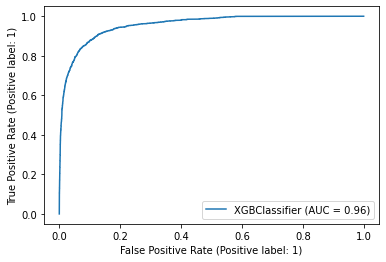

Train AUC 0.972152701813672
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     31010
           1       0.92      0.72      0.81      9303

    accuracy                           0.92     40313
   macro avg       0.92      0.85      0.88     40313
weighted avg       0.92      0.92      0.92     40313



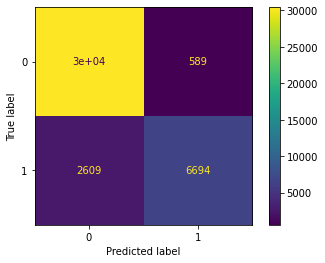

Test AUC 0.9563832471833511
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     15260
           1       0.80      0.65      0.72      1784

    accuracy                           0.95     17044
   macro avg       0.88      0.82      0.84     17044
weighted avg       0.94      0.95      0.94     17044



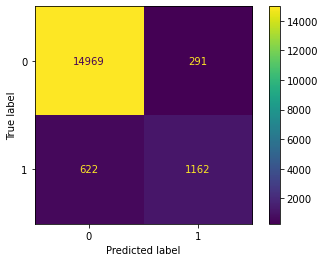

In [32]:
metrics(model_result_xgboost.best_estimator_, X_train_smote, X_test, y_train_smote, y_test, thr=0.5)

### Resultados primera iteración (incorrecto aplicación de smote sobre muetra para test)

In [11]:
#Ahora todos los modelos los usamos con la data train para obtener las probabilidades
y_pred = model_result_xgboost.predict(X_train)
probs = model_result_xgboost.predict_proba(X_train)
print('Train AUC:', roc_auc_score(y_train,probs[:,1]))

#Ahora evaluo el resultado con la data de test
y_pred = model_result_xgboost.predict(X_test)
probs = model_result_xgboost.predict_proba(X_test)
print(" Test AUC:", roc_auc_score(y_test,probs[:,1]))

Train AUC: 0.9630412048830986
 Test AUC: 0.9621369872399149


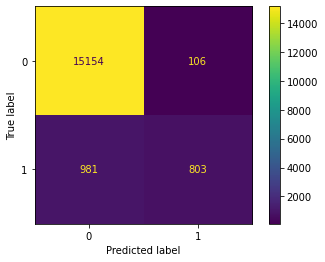

In [9]:
#plot_confusion_matrix(model_result,  X_test, y_test) funcion deprecada en futuras versiones
cm = confusion_matrix(y_test,y_pred)
disp =ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_result_xgboost.classes_)
disp.plot()
plt.show()

In [10]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9534261331244968


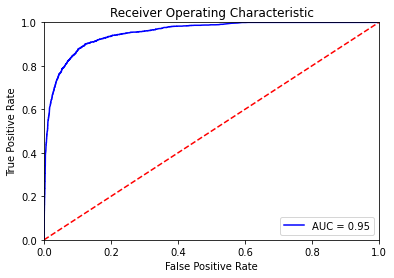

In [11]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
print(classification_report(y_test,y_pred,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     15260
           1       0.88      0.45      0.60      1784

    accuracy                           0.94     17044
   macro avg       0.91      0.72      0.78     17044
weighted avg       0.93      0.94      0.93     17044

